In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft, fftfreq
from scipy.io import loadmat
from scipy.signal import savgol_filter
import xlsxwriter 
%matplotlib inline

In [2]:
def NGD(x):
    y=np.zeros(len(T))
    z=np.zeros(len(T))
    for j in range(len(T)-1):
        dy=dt*(-alpha*y[j]+K*(x[j]-z[j]))
        dz=dt*(-beta*z[j]+g*y[j])
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
    return y,z

In [3]:
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate

In [4]:
def MI(xstate,ystate,dt,window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftdu=dt # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen))
    xedges=np.arange(min(xstate),max(xstate)+0.0001)
    yedges=np.arange(min(ystate),max(ystate)+0.0001)
    
    # shifted data
    # shift>0 => y shifted to positive side
    MI=np.zeros(len(bitshift))
    for i in range(len(bitshift)):
        xx=[]
        yy=[]
        shift=int(bitshift[i])
        if shift>0:
            xx=xstate[shift:]
            yy=ystate[:-shift]
        elif shift==0:
            xx=xstate
            yy=ystate
        elif shift<0:
            xx=xstate[:shift]
            yy=ystate[-shift:]

        H, xedges, yedges = np.histogram2d(xx, yy, bins=(xedges, yedges))
        statesum=np.sum(H)
        px_list=np.sum(H,axis=1)/statesum
        py_list=np.sum(H,axis=0)/statesum
        pxy_list=H/statesum

        MIsingle=np.zeros((len(px_list),len(py_list)))
        for ix in range(len(px_list)):
            for iy in range(len(py_list)):
                if pxy_list[ix][iy]==0:
                    MIsingle[ix][iy]=0
                else:
                    MIsingle[ix][iy]=pxy_list[ix][iy]*math.log2(pxy_list[ix][iy]/px_list[ix]/py_list[iy])
        MI[i]=np.sum(MIsingle)
    return timeshift,MI

In [5]:
def FFT_quick(data):
    Ts=dt
    xft=fft(data)
    xftreal = xft.real  
    xftimg = xft.imag
    xft_abs=abs(xft)
    xft_nor=xft_abs/len(xft_abs)
    xft_nor2=xft_nor[range(int(len(xft_nor)/2))]
    freq=fftfreq(len(x), d=dt)
    freq=freq[range(int(len(freq)/2))]
    phase=np.angle(xft)
    phase=phase[range(int(len(phase)/2))]
    
    return freq,xft_nor2,phase

In [6]:
# NGD parameter 
# alpha = 6
# beta = 1.2
# K = 22
# g = 10
alpha, beta, K, g =6,1.6,22,10

In [7]:
# numerical result looping and averaging
phi_avg=0
group_avg=0
gain_avg=0
num_loop=30
for num in range(num_loop):
    # OU
    Tot=300
    dt=0.001
    T=np.arange(dt,Tot,dt)
    tau=0.6
    D = 4
    L=np.zeros(len(T))
    mu, sigma = 0, 1
    for i in range(len(T)-1):
        L[i+1]=L[i]*(1-dt/tau)+math.sqrt(D*dt)*np.random.normal(mu,sigma)
    # filtering
    fc=10
    b, a = signal.butter(2, 2*fc*dt, btype='low', analog=False)
    x = signal.filtfilt(b, a, L)
    
    y,z=NGD(x)

    freq,p1,phasex=FFT_quick(x)
    freq,p2,phasey=FFT_quick(y)

    # phase for numerical input
    phi=phasey-phasex
    for i in range(len(phi)-1):
        if phi[i+1]-phi[i]>math.pi:
            phi[i+1]=phi[i+1]-2*math.pi
        elif phi[i+1]-phi[i]<-math.pi:
            phi[i+1]=phi[i+1]+2*math.pi

    # group for numerical input
    df=freq[1]-freq[0]
    domega=df*2*math.pi
    dphi=np.diff(phi)
    delta=-dphi/domega
    delta_new=savgol_filter(delta, 51, 1)
    
    # gain 
    G=p2/p1
    
    phi_avg=phi_avg+phi
    group_avg=group_avg+delta_new
    gain_avg=gain_avg+G
phi_avg=phi_avg/num_loop
group_avg=group_avg/num_loop
gain_avg=gain_avg/num_loop

(-2.0, 4.0)

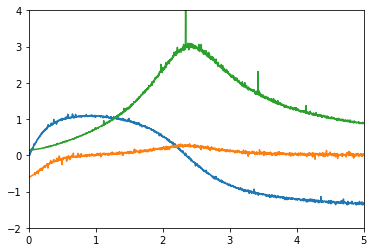

In [8]:
plt.plot(freq,phi_avg)
plt.plot(freq[:-1],group_avg)
plt.plot(freq,gain_avg)
plt.xlim(0,5)
plt.ylim(-2,4)

In [9]:
# save excel file of numerical data
workbook = xlsxwriter.Workbook('F:/我的雲端硬碟/Retina exp/Retina as NGD paper submit/data/NGD_numerical_result.xlsx') 
worksheet = workbook.add_worksheet()
for i in range(len(freq[freq<5])):
    worksheet.write(i,0,freq[i])
    worksheet.write(i,1,phi_avg[i])
    worksheet.write(i,2,group_avg[i])
    worksheet.write(i,3,gain_avg[i])
workbook.close()

In [10]:
# analytic result 
omega=np.arange(0,50,0.001)
A=np.zeros(len(omega))
B=np.zeros(len(omega))
for i in range(len(omega)):
    A[i]=alpha*beta**2+g*beta*K+omega[i]**2*alpha
    B[i]=-omega[i]**3+omega[i]*g*K-beta**2*omega[i]
# phase
phi_ana=np.zeros(len(omega))
for i in range(len(omega)):
    phi_ana[i]=math.atan(B[i]/A[i])
# group
delta_ana=-np.diff(phi_ana)/(omega[1]-omega[0])
# gain
C=np.zeros(len(omega))
for i in range(len(omega)):
    C[i]=(-omega[i]**2+alpha*beta+g*K)**2+(omega[i]*(alpha+beta))**2
gain_ana=K/C*(A**2+B**2)**(1/2)

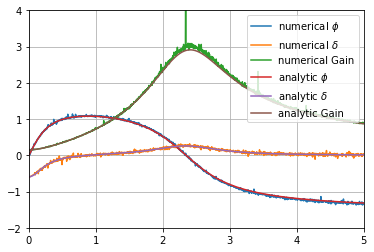

In [11]:
# plt.plot(freq,phi)
# plt.plot(freq[0:-1],delta_new)
# plt.plot(freq,p2/p1)

plt.plot(freq,phi_avg)
plt.plot(freq[0:-1],group_avg)
plt.plot(freq,gain_avg)

plt.plot(omega/2/math.pi,phi_ana)
plt.plot(omega[0:-1]/2/math.pi,delta_ana)
plt.plot(omega/2/math.pi,gain_ana)

plt.xlim(0,5)
plt.ylim(-2,4)
# plt.ylim(-0.2,0.5)
plt.legend(('numerical $\phi$','numerical $\delta$','numerical Gain','analytic $\phi$','analytic $\delta$','analytic Gain'))
plt.grid()

In [27]:
print(freq[np.argmax(gain_avg[freq<5])])

2.340007800026


In [12]:
# save excel file of analytic data
workbook = xlsxwriter.Workbook('F:/我的雲端硬碟/Retina exp/Retina as NGD paper submit/data/NGD_analytic_result.xlsx') 
f_ana=omega/2/math.pi
worksheet = workbook.add_worksheet()
for i in range(len(f_ana[f_ana<5])):
    worksheet.write(i,0,f_ana[i])
    worksheet.write(i,1,phi_ana[i])
    worksheet.write(i,2,delta_ana[i])
    worksheet.write(i,3,gain_ana[i])
workbook.close()

Text(0, 0.5, 'group delay (s)')

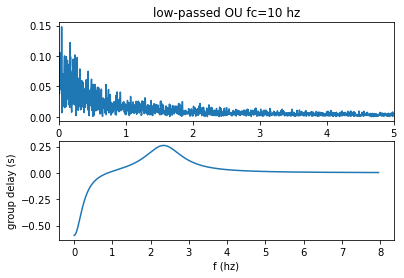

In [13]:
plt.subplot(2,1,1)
plt.title('low-passed OU fc=10 hz')
plt.plot(freq,p1)
# plt.plot(freq,p2)
plt.xlim(0,5)
plt.subplot(2,1,2)
plt.plot(omega[0:-1]/2/math.pi,delta_ana)
# plt.plot(omega/2/math.pi,gain_ana)
plt.xlabel('f (hz)')
plt.ylabel('group delay (s)')
# plt.legend(('group delay (s)','gain'))

In [14]:
xycorr=np.correlate(x,y,'full')

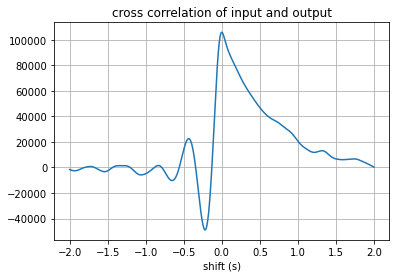

In [15]:
negwindow=2
poswindow=2
TS=np.arange(-negwindow,poswindow+1e-10,dt)
index_mid=int((len(xycorr)+1)/2)
corr_select=xycorr[index_mid-int(negwindow/dt):index_mid+int(poswindow/dt)+1]
plt.plot(TS,corr_select)
plt.xlabel('shift (s)')
plt.title('cross correlation of input and output')
plt.xlim()
plt.grid()

In [16]:
print(TS[np.argmax(corr_select)])
print(TS[np.argmin(corr_select)])

-0.0010000000002201581
-0.22100000000019593


In [17]:
# OU
Tot=300
dt=0.01
T=np.arange(dt,Tot,dt)
D = 4
tau=0.1
mu, sigma = 0, 1
randterm=np.random.normal(mu,sigma,len(T)-1)
L=np.zeros(len(T))
for i in range(len(T)-1):
    L[i+1]=L[i]*(1-dt/tau)+math.sqrt(D*dt)*randterm[i]
x=[[] for k in range(3)]
fc=[7,4,2]
for n in range(len(fc)):
    b, a = signal.butter(2, 2*fc[n]*dt, btype='low', analog=False)
    Lf = signal.filtfilt(b, a, L)
    Lf=Lf/np.std(Lf)
    x[n]=Lf

In [18]:
alpha, beta, K, g =10,1.4,30,10
y=[[] for k in range(3)]
for i in range(3):
    y[i],z=NGD(x[i])

(100.0, 110.0)

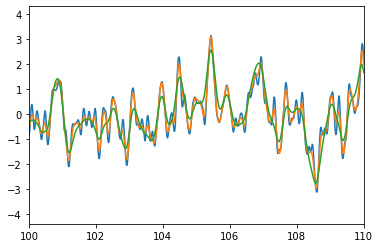

In [19]:
for i in range(3):
    plt.plot(T,x[i])
plt.xlim(100,110)

(-1499.9, 31497.9)

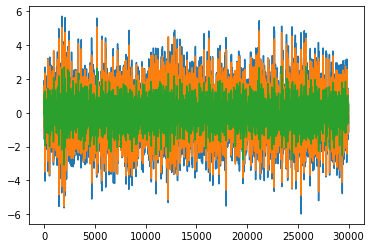

In [20]:
plt.plot(y[0])
plt.plot(y[1])
plt.plot(y[2])
plt.xlim()

In [21]:
xycorr1=np.correlate(x[0],y[0],'full')
xycorr2=np.correlate(x[1],y[1],'full')
xycorr3=np.correlate(x[2],y[2],'full')

negwindow=2
poswindow=2
TS=np.arange(-negwindow,poswindow+1e-10,dt)
index_mid=int((len(xycorr)+1)/2)
c1=xycorr1[index_mid-int(negwindow/dt):index_mid+int(poswindow/dt)+1]
c2=xycorr2[index_mid-int(negwindow/dt):index_mid+int(poswindow/dt)+1]
c3=xycorr3[index_mid-int(negwindow/dt):index_mid+int(poswindow/dt)+1]

ValueError: x and y must have same first dimension, but have shapes (401,) and (0,)

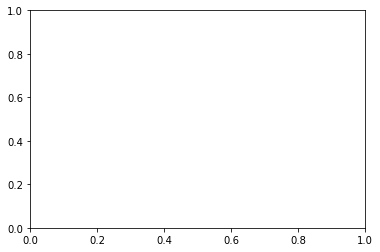

In [22]:
# plt.plot(TS,c1)
plt.plot(TS,c2)
# plt.plot(TS,c3)
plt.plot(2)
plt.grid()
plt.xlabel('shift (s)')
plt.title('cross correlation of input and output')

In [ ]:
plt.plot(TS,c3)

In [ ]:
# analytic result as a function
def NGD_analytic(alpha, beta, K, g):
    omega=np.linspace(0,30,10000)
    A=np.zeros(len(omega))
    B=np.zeros(len(omega))
    for i in range(len(omega)):
        A[i]=alpha*beta**2+g*beta*K+omega[i]**2*alpha
        B[i]=-omega[i]**3+omega[i]*g*K-beta**2*omega[i]
    # phase
    phi_ana=np.zeros(len(omega))
    for i in range(len(omega)):
        phi_ana[i]=math.atan(B[i]/A[i])
    # group
    delta_ana=-np.diff(phi_ana)/(omega[1]-omega[0])
    # gain
    C=np.zeros(len(omega))
    for i in range(len(omega)):
        C[i]=(-omega[i]**2+alpha*beta+g*K)**2+(omega[i]*(alpha+beta))**2
    gain_ana=K/C*(A**2+B**2)**(1/2)
    return phi_ana, delta_ana, gain_ana, omega/2/math.pi

In [ ]:
alpha_set=[5,10,15,20]
fig = plt.figure(figsize=(8,8))
ax1=fig.add_subplot(2,1,1)
ax2=fig.add_subplot(2,1,2)
for i in range(len(alpha_set)):
    phi_temp,delta_temp,gain_temp,f_temp=NGD_analytic(alpha_set[i],1.4,30,10)
    ax1.plot(f_temp,gain_temp)
    ax2.plot(f_temp[:-1],delta_temp,'--')
legend_list=['alpha='+str(alpha_set[j]) for j in range(len(alpha_set))]
ax1.legend((legend_list))
ax2.legend((legend_list))
ax1.set_title('Gain')
ax2.set_title('Group delay')

In [ ]:
K_set=[10,20,30,40]
fig = plt.figure(figsize=(8,8))
ax1=fig.add_subplot(2,1,1)
ax2=fig.add_subplot(2,1,2)
for i in range(len(K_set)):
    phi_temp,delta_temp,gain_temp,f_temp=NGD_analytic(10,1.4,K_set[i],10)
    ax1.plot(f_temp,gain_temp)
    ax2.plot(f_temp[:-1],delta_temp,'--')
legend_list=['K='+str(K_set[j]) for j in range(len(K_set))]
ax1.legend((legend_list))
ax2.legend((legend_list))
ax1.set_title('Gain')
ax2.set_title('Group delay')

In [ ]:
beta_set=[0.5,0.8,1.3,2]
fig = plt.figure(figsize=(8,8))
ax1=fig.add_subplot(2,1,1)
ax2=fig.add_subplot(2,1,2)
for i in range(len(beta_set)):
    phi_temp,delta_temp,gain_temp,f_temp=NGD_analytic(10,beta_set[i],30,10)
    ax1.plot(f_temp,gain_temp)
    ax2.plot(f_temp[:-1],delta_temp,'--')